<a href="https://colab.research.google.com/github/og-hayden/ai-ml/blob/main/PyTorch_Iris_Multi_class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [74]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [75]:
df = pd.read_csv("/content/IRIS.csv")
df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [76]:
df.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [77]:
df['species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64

In [78]:
df_encoded = pd.get_dummies(df, columns=['species'], drop_first=False)
df_encoded.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species_Iris-setosa,species_Iris-versicolor,species_Iris-virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0


In [79]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = df_encoded.drop(['species_Iris-setosa',	'species_Iris-versicolor',	'species_Iris-virginica'], axis=1)
y = df_encoded[['species_Iris-setosa',	'species_Iris-versicolor',	'species_Iris-virginica']]

X.head(3)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [80]:
y.head(3)

,species_Iris-setosa,species_Iris-versicolor,species_Iris-virginica
0,1,0,0
1,1,0,0
2,1,0,0


In [81]:
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X.head(3)

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8, shuffle=True)

In [83]:
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

In [84]:
X_train, X_test = torch.tensor(X_train).to(device).type(torch.float32), torch.tensor(X_test).to(device).type(torch.float32)
y_train, y_test = torch.tensor(y_train).to(device).type(torch.float32), torch.tensor(y_test).to(device).type(torch.float32)

In [85]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(4, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 8),
        nn.ReLU(),
        nn.Linear(8, 3),
    )
  def forward(self, x):
    return self.layer_stack(x)

In [86]:
model = Model().to(device)

In [87]:
with torch.inference_mode():
  model.eval()
  pred_probs = torch.nn.functional.softmax((model(X_test[:5])), dim=1)
torch.argmax(pred_probs, dim=1)

tensor([0, 0, 0, 0, 0], device='cuda:0')

In [88]:
torch.argmax(y_test[:5], dim=1)

tensor([1, 0, 2, 1, 1], device='cuda:0')

In [89]:
loss_fn = nn.CrossEntropyLoss() # includes softmax
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [90]:
epochs = 1000

train_history = {}
test_history = {}

best_loss = float('inf')
patience = 10
num_unimproved_epochs = 0

for epoch in range(epochs):
  model.train()
  optimizer.zero_grad()
  y_pred_logits = model(X_train).squeeze()
  loss = loss_fn(y_pred_logits, y_train)
  loss.backward()
  optimizer.step()
  train_history[epoch] = loss.item()

  model.eval()
  with torch.inference_mode():
    y_test_logits = model(X_test).squeeze()
  test_loss = loss_fn(y_test_logits, y_test)
  test_history[epoch] = test_loss.item()

  if test_loss < best_loss:
    num_unimproved_epochs = 0
    best_loss = test_loss
    best_params = model.state_dict()
  else:
    num_unimproved_epochs += 1

  if (epoch + 1) % 100 == 0:
    print(f"Epoch {epoch} | Train Loss: {loss} | Test Loss: {test_loss}")

  if num_unimproved_epochs > patience:
    model.load_state_dict(best_params)
    print(f"Early stop at epoch {epoch}.")
    break

Epoch 99 | Train Loss: 0.4957687556743622 | Test Loss: 0.4570484757423401
Epoch 199 | Train Loss: 0.13316944241523743 | Test Loss: 0.11490277200937271
Epoch 299 | Train Loss: 0.05199919641017914 | Test Loss: 0.033479247242212296
Epoch 399 | Train Loss: 0.03992404416203499 | Test Loss: 0.016969997435808182
Epoch 499 | Train Loss: 0.03479984030127525 | Test Loss: 0.012446903623640537
Epoch 599 | Train Loss: 0.030070465058088303 | Test Loss: 0.010474789887666702
Epoch 699 | Train Loss: 0.02386082336306572 | Test Loss: 0.009296943433582783
Early stop at epoch 798.


In [91]:
train_epochs = list(train_history.keys())
train_losses = list(train_history.values())
test_epochs = list(test_history.keys())
test_losses = list(test_history.values())

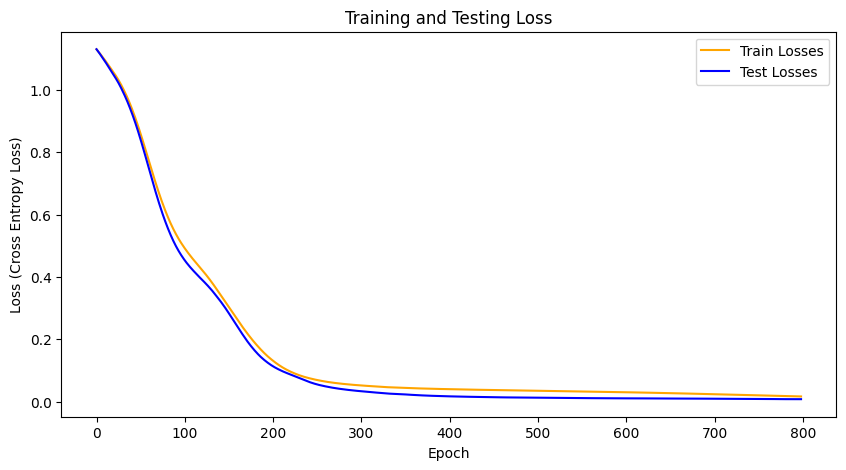

In [92]:
plt.figure(figsize=(10, 5))
plt.title("Training and Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Cross Entropy Loss)")
plt.plot(train_epochs, train_losses, label="Train Losses", color='orange')
plt.plot(test_epochs, test_losses, label="Test Losses", color='blue')
plt.legend()
plt.show()